In [1]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql import types as T

import seaborn as sns

In [2]:
sns.set_style('ticks')
sns.set_context('paper')

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['lines.markersize'] = 3
matplotlib.rcParams['lines.linewidth'] = 1

pd.options.display.width = 200


In [3]:
DATA_DIR = "data"
PLOT_DIR = "plots"
OUT_DIR = "output"
columns = ["PMID", "Year", "AbsVal", "TFirstP", "VolFirstP",
           "acc_pos_vel_min", "acc_pos_vel_max", "acc_neg_vel_max", "acc_neg_vel_min",
           "Pair_AbsVal", "Pair_TFirstP", "Pair_VolFirstP", "Mesh_counts", "Exploded_Mesh_counts"]



In [4]:
df = sqlContext.read.format("csv").options(header='false', inferschema='true', delimiter='\t').load("out/pmid_novelty_all_scores_mesh_c.txt")
df = df.selectExpr(*("%s as %s" % (df.columns[i], k) for i,k in enumerate(columns)))
print df

for k in ["acc_pos_vel_min", "acc_pos_vel_max", "acc_neg_vel_max", "acc_neg_vel_min",
          "Pair_AbsVal", "Pair_TFirstP", "Pair_VolFirstP"]:
    df = df.withColumn(k, df[k].cast(T.DoubleType()))
print df

DataFrame[PMID: int, Year: int, AbsVal: int, TFirstP: int, VolFirstP: double, acc_pos_vel_min: string, acc_pos_vel_max: string, acc_neg_vel_max: string, acc_neg_vel_min: string, Pair_AbsVal: string, Pair_TFirstP: string, Pair_VolFirstP: string, Mesh_counts: int, Exploded_Mesh_counts: int]
DataFrame[PMID: int, Year: int, AbsVal: int, TFirstP: int, VolFirstP: double, acc_pos_vel_min: double, acc_pos_vel_max: double, acc_neg_vel_max: double, acc_neg_vel_min: double, Pair_AbsVal: double, Pair_TFirstP: double, Pair_VolFirstP: double, Mesh_counts: int, Exploded_Mesh_counts: int]


In [5]:
# Get data for distribution of Scores
score_types = ["TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"]
bins = [range(60), reduce(lambda x, y: x + y, [[0]] + [(10**k*np.arange(1,10)).tolist() for k in range(6)])]
data = []
for i, k in enumerate(score_types):
    print "Processing %s" % k
    j = i % 2
    x, y = df[(df["Year"] >= 1985)].rdd.map(lambda x: x[k]).histogram(bins[j])
    data.append((x,y))



Processing TFirstP
Processing VolFirstP
Processing Pair_TFirstP
Processing Pair_VolFirstP


Plotting TFirstP
Plotting VolFirstP
Plotting Pair_TFirstP
Plotting Pair_VolFirstP


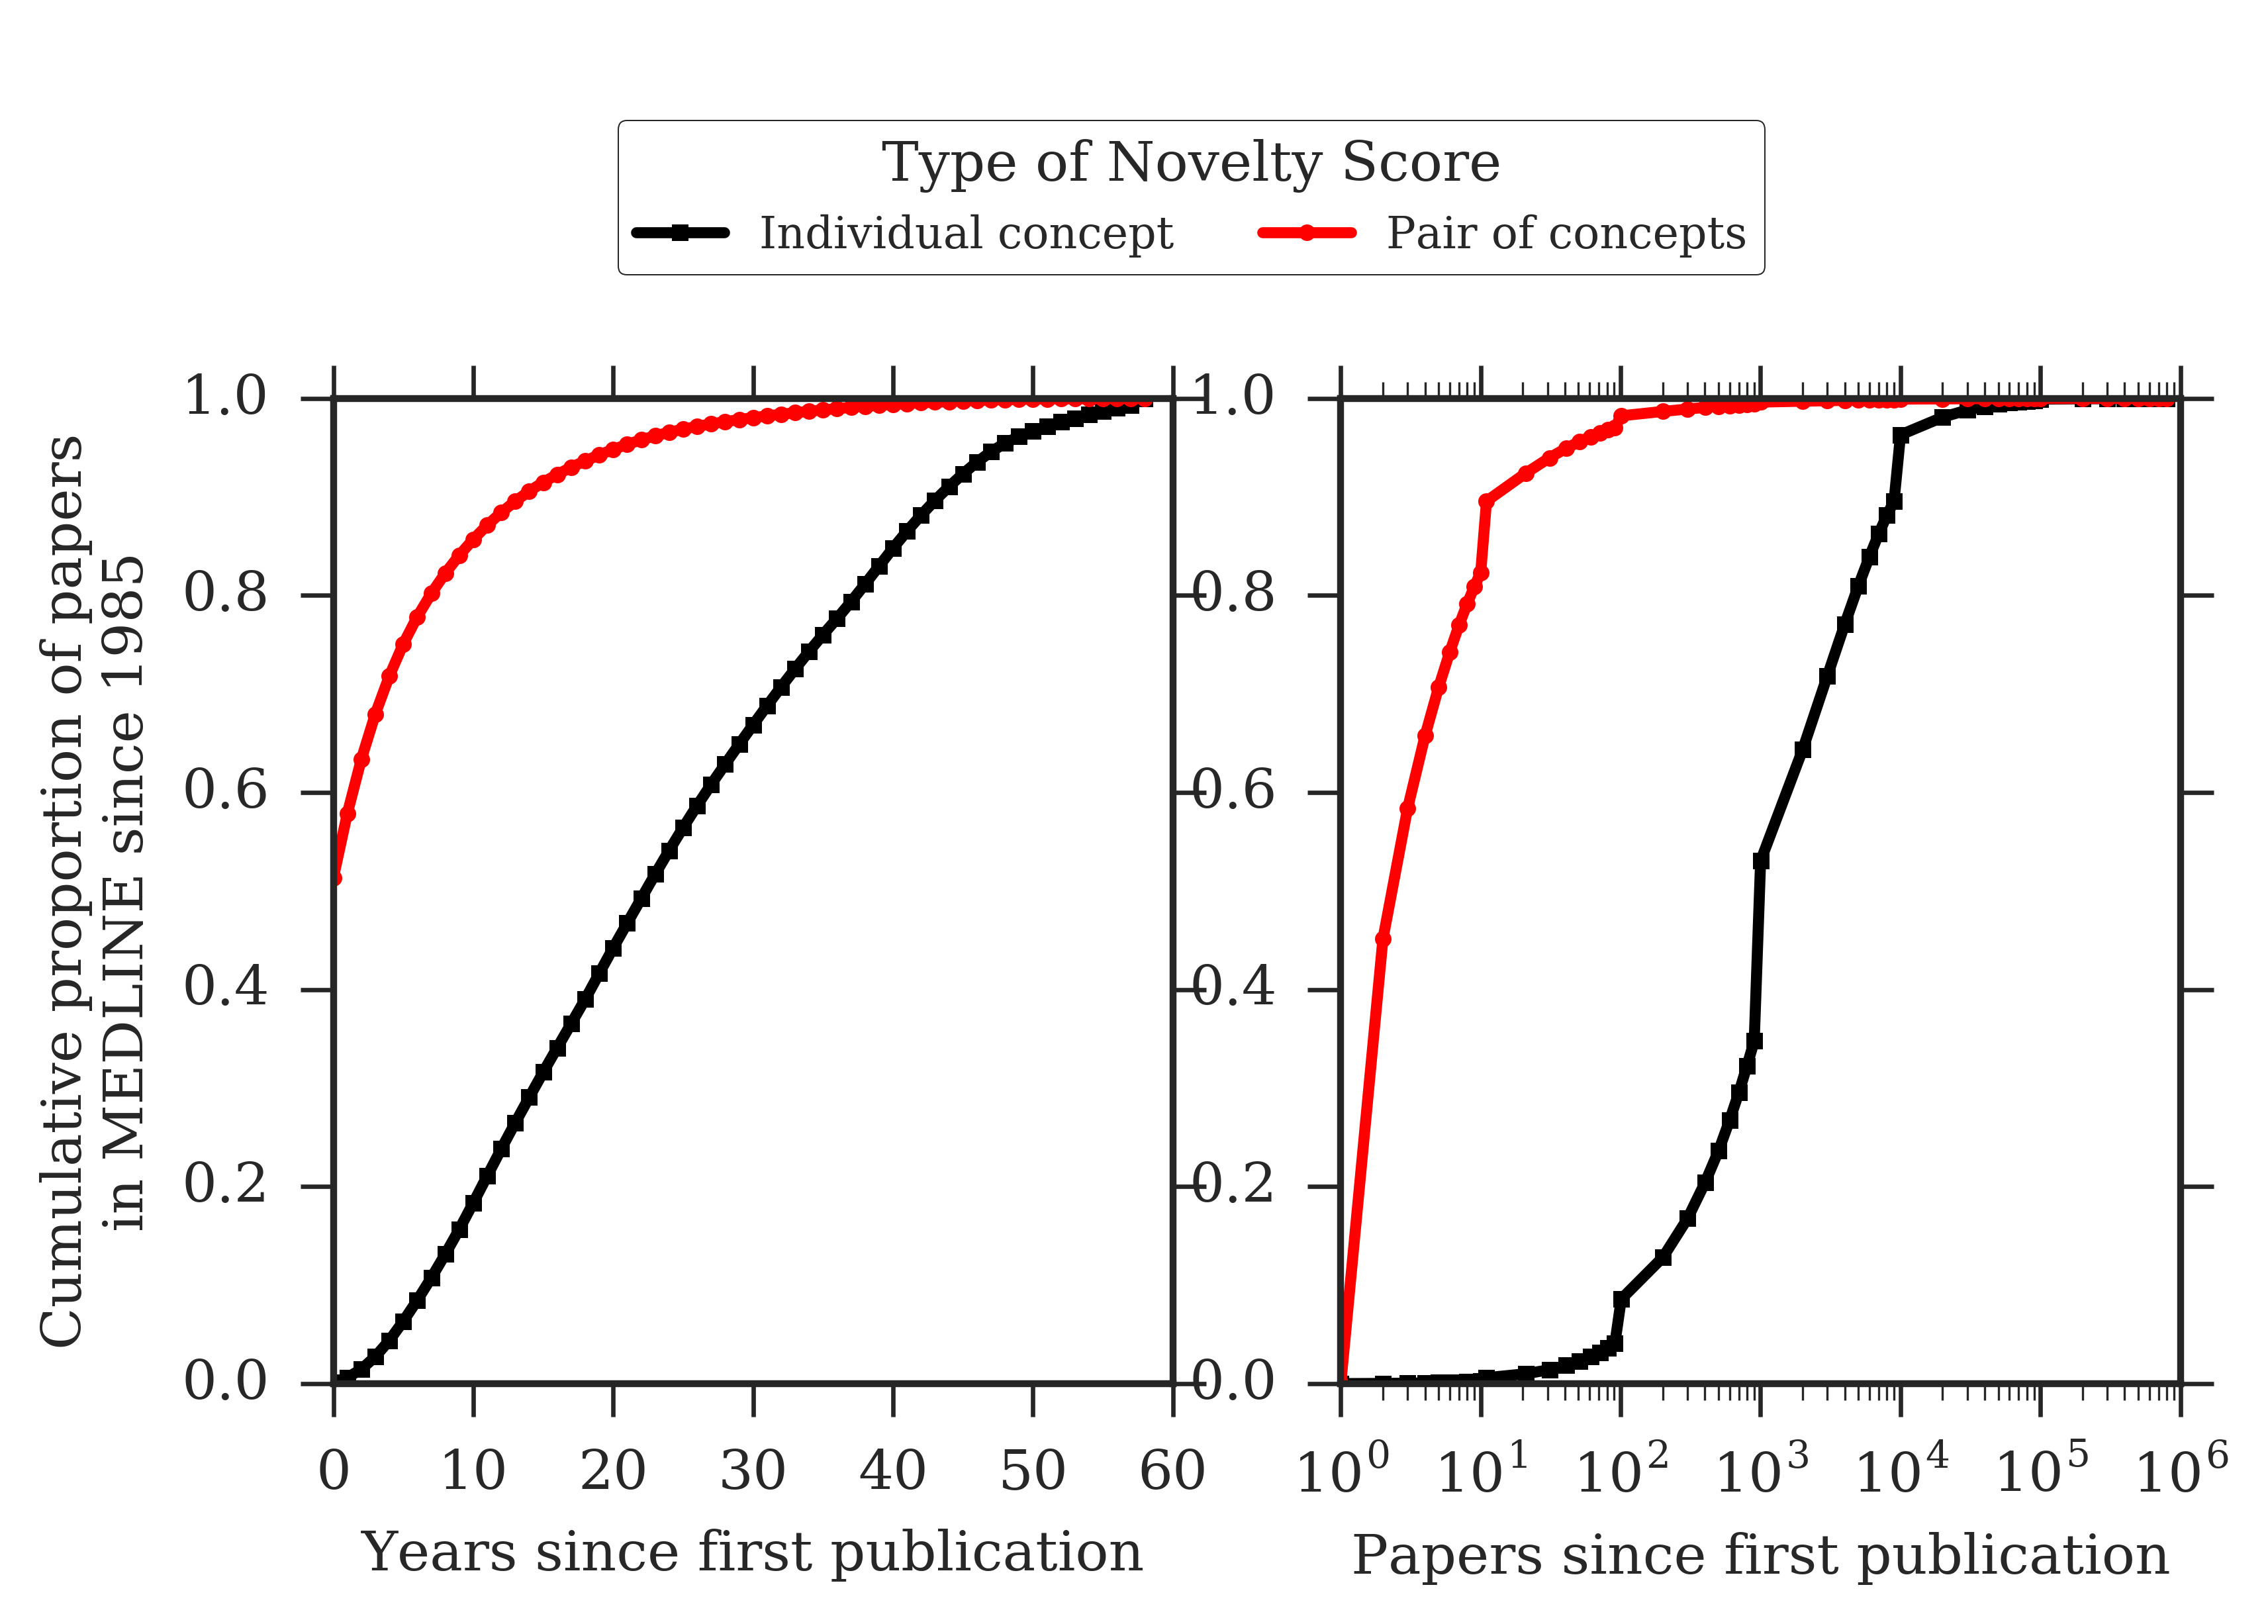

In [6]:
# Plot distribion data
plt.close("all")
plt.clf()
fig, ax = plt.subplots(1,2, figsize=(6,3.2))

y_label = "Cumulative proportion of papers\nin MEDLINE since 1985"
x_labels = ["Years since first publication", "Papers since first publication"]
labels = ["Individual concept", "Pair of concepts"]
colors = ["black", "red"]
markers = ["s", "o"]

for i, k in enumerate(score_types):
    print "Plotting %s" % k
    j = i % 2
    x, y = data[i]
    x = np.array(x[:-1])
    if "VolFirstP" in k:
        x = x + 1.0
    y = np.cumsum(y) * 1.0 / np.sum(y)
    ax[j].plot(x, y, marker=markers[i/2], color=colors[i/2], label=labels[i/2], lw=2)

ax[0].set_ylabel(y_label)
ax[0].set_xlabel(x_labels[0])
ax[1].set_xscale("log")
ax[1].set_xlabel(x_labels[1])
lgd = fig.legend(*ax[0].get_legend_handles_labels(),
    loc = 'upper center',bbox_to_anchor=(0.5, 1.2),
    title = "Type of Novelty Score",
    ncol=2, frameon=True, fancybox=True)
plt.savefig("%s/ScoreDistribution.pdf" % PLOT_DIR, bbox_inches='tight', bbox_extra_artists=[lgd])


In [7]:
cutoff = [3,20]
for i, k in enumerate(score_types):
    df_t = pd.DataFrame({"x": data[i][0][:-1], "y": data[i][1]})
    prop = df_t[df_t.x <= cutoff[i%2]].y.sum() * 100./ df_t.y.sum()
    print "Percentage of papers with %s less than %s = %.4f%%" % (k,cutoff[i%2], prop)


Percentage of papers with TFirstP less than 3 = 2.7431%
Percentage of papers with VolFirstP less than 20 = 0.9982%
Percentage of papers with Pair_TFirstP less than 3 = 67.9664%
Percentage of papers with Pair_VolFirstP less than 20 = 92.4209%


In [8]:
# Growth data
score_types = ["acc_pos_vel_min", "acc_neg_vel_max"]
bins = [-0.1, 0] + np.logspace(-45,0,100).tolist() + [1.1]
data_acc_growth = df[(df["Year"] >= 1985) & (~df["acc_pos_vel_min"].isNull())].rdd.map(lambda x: min(x["acc_pos_vel_min"], 1)).histogram(bins)
bins = [-0.1, 0] + np.logspace(-10,0,100).tolist() + [1.1]
data_dec_growth = df[(df["Year"] >= 1985) & (df["acc_pos_vel_min"].isNull())].rdd.map(lambda x: min(x["acc_neg_vel_max"], 1)).histogram(bins)


Plotting acc_pos_vel_min
Plotting acc_neg_vel_max


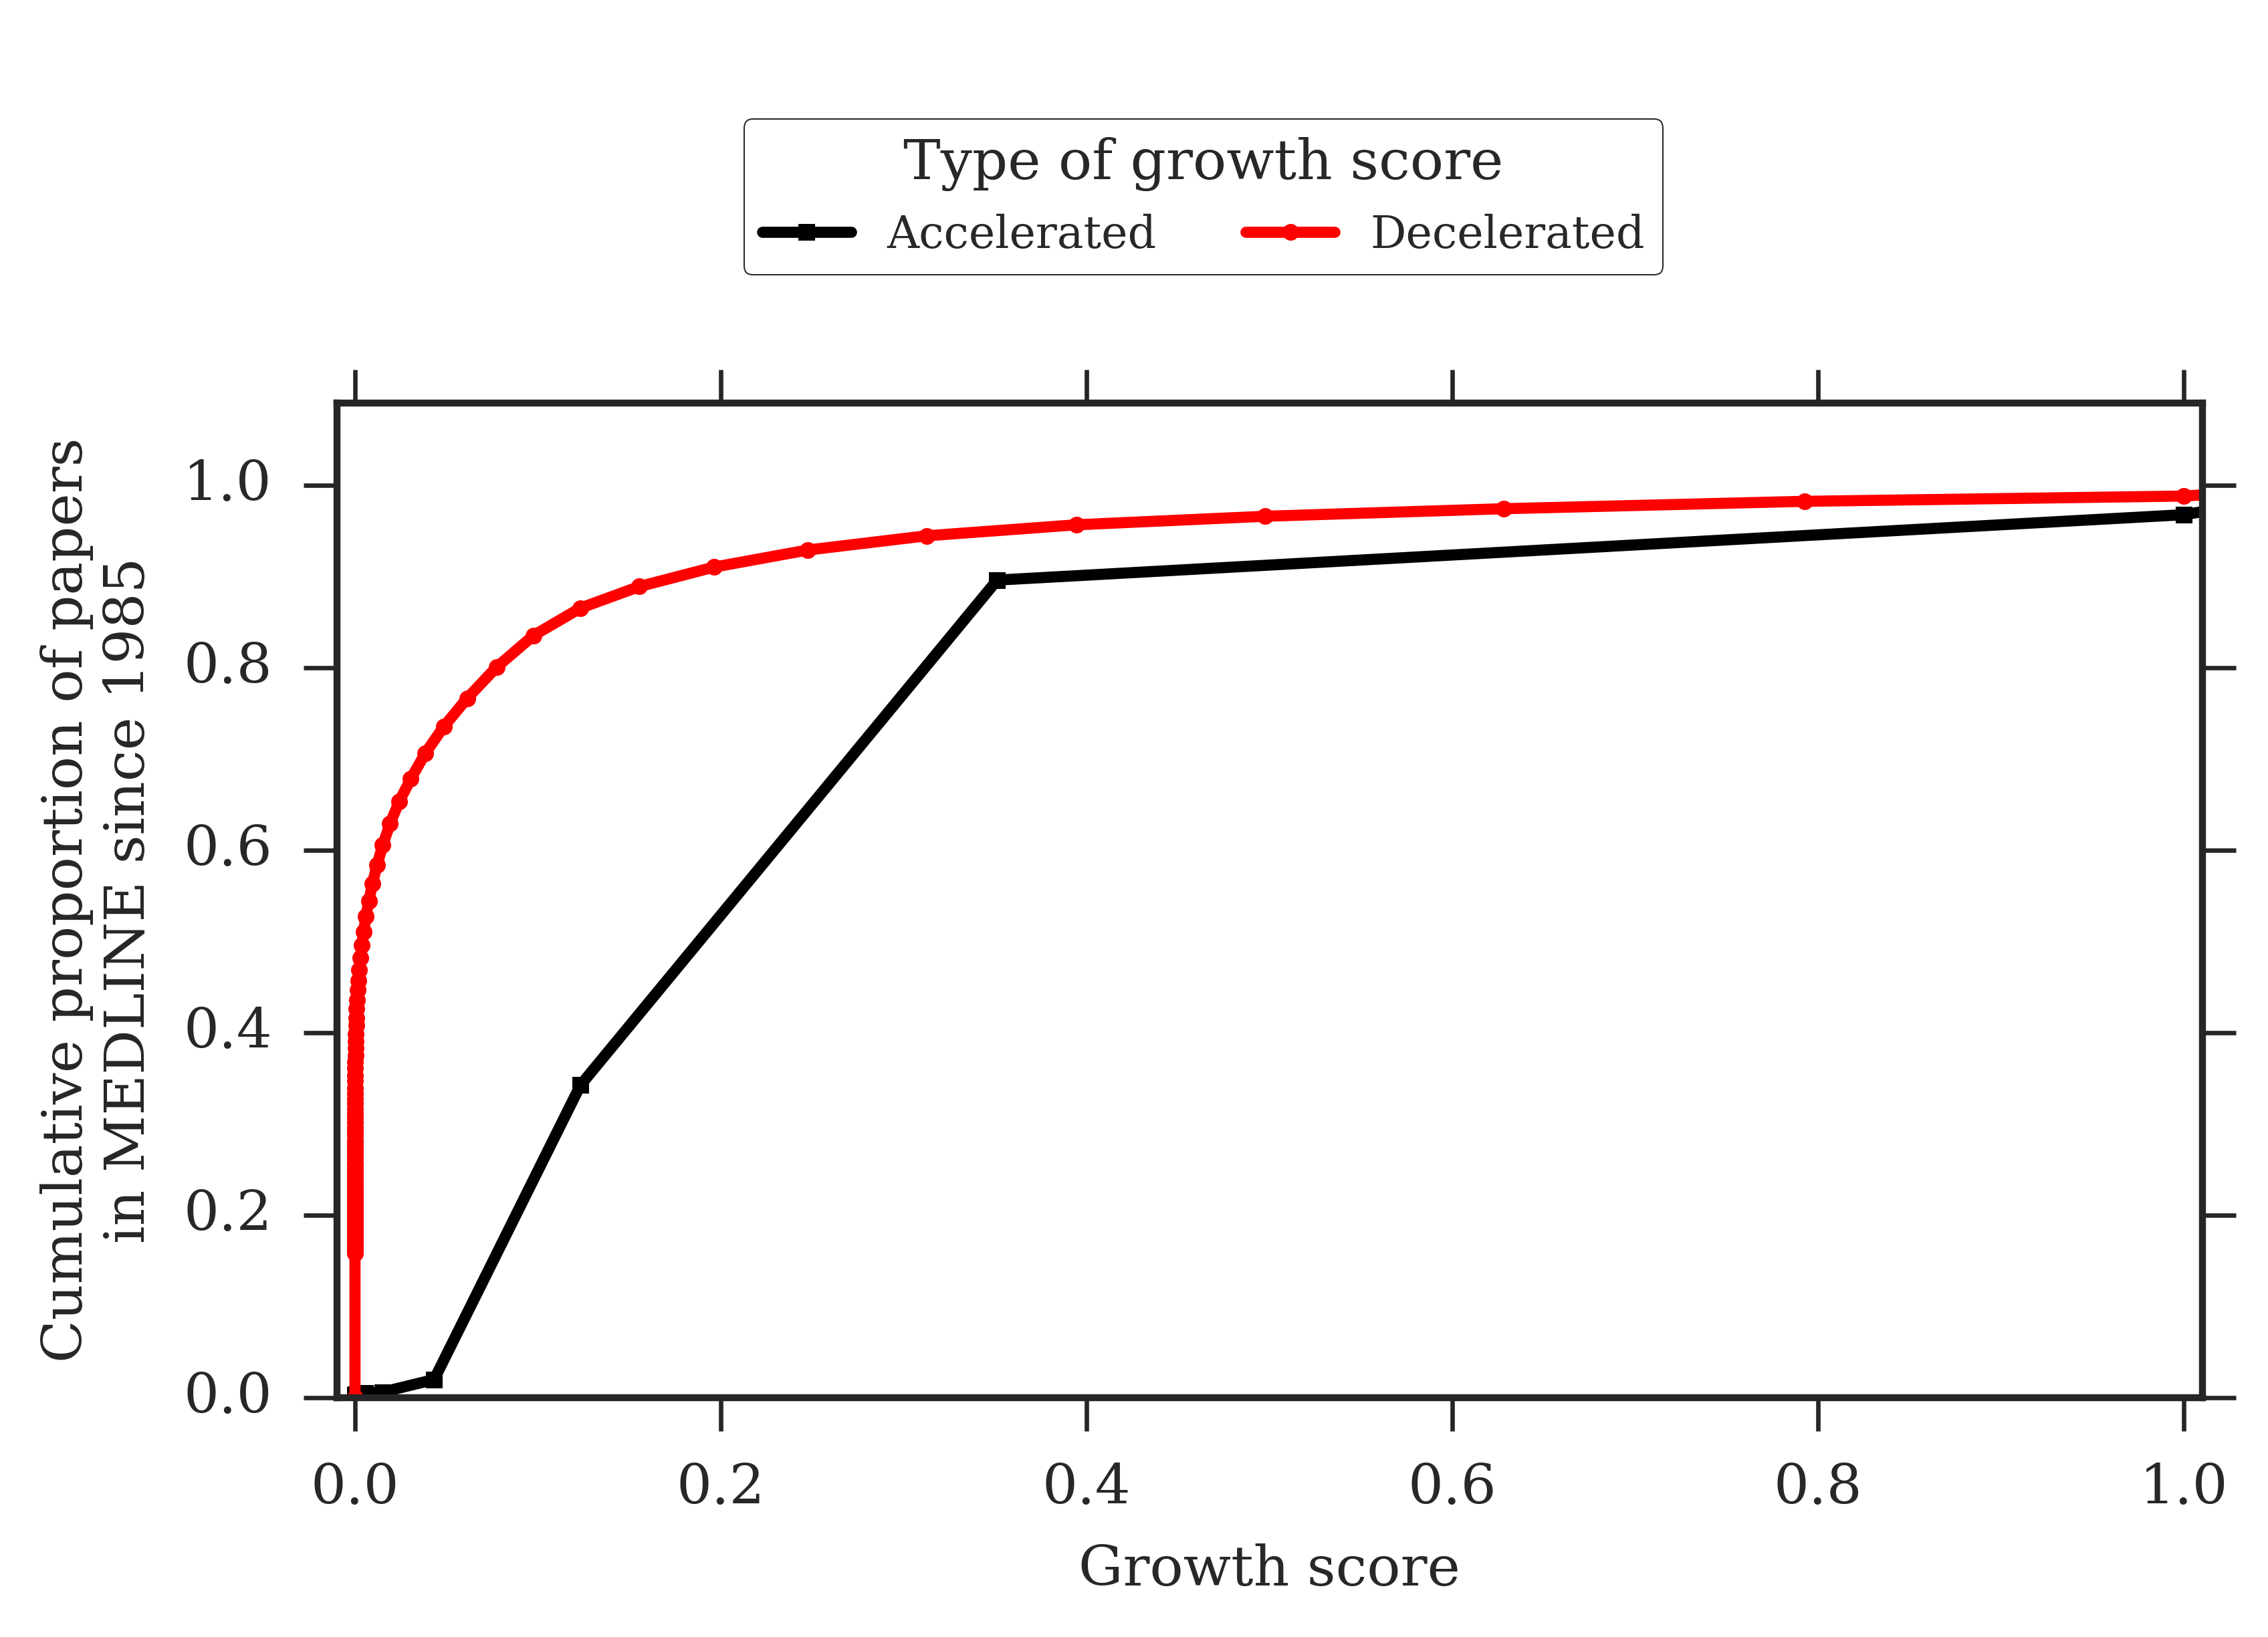

In [9]:
data = [data_acc_growth, data_dec_growth]

plt.close("all")
plt.clf()
fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,3.2))

y_label = "Cumulative proportion of papers\nin MEDLINE since 1985"
x_labels = "Growth score"
labels = ["Accelerated", "Decelerated"]
colors = ["black", "red"]
markers = ["s", "o"]

for i, k in enumerate(score_types):
    print "Plotting %s" % k
    x, y = data[i]
    x = np.array(x[1:])
    y = np.cumsum(y) * 1.0 / np.sum(y)
    ax.plot(x, y, marker=markers[i], color=colors[i], label=labels[i], lw=2)

ax.set_ylabel(y_label)
ax.set_xlabel(x_labels)
ax.set_ylim([0,1.09])
ax.set_xlim([-0.01,1.01])
#ax.set_xscale("log")

lgd = fig.legend(*ax.get_legend_handles_labels(),
    loc = 'upper center',bbox_to_anchor=(0.5, 1.2),
    title = "Type of growth score",
    ncol=2, frameon=True, fancybox=True)
plt.savefig("%s/GrowthScoreDistribution.pdf" % PLOT_DIR, bbox_inches='tight', bbox_extra_artists=[lgd])
##plt.savefig("%s/GrowthScoreDistribution.pdf" % PLOT_DIR, bbox_inches='tight')

In [10]:
data_acc_growth[1][0]* 100.0/ sum(data_acc_growth[1])

0.0

In [11]:
t = np.array([sum(data_acc_growth[1]),sum(data_dec_growth[1])])
t * 100./ t.sum()

array([  2.50148836,  97.49851164])